# Classes declaration

In [1]:
class Relations():
    RIGHT_CAUSALITY='->'
    LEFT_CAUSALITY='<-'
    PARALLEL='||'
    NONE='#'

class GateTypes():
    XOR = 'XOR'
    AND = 'AND'

In [3]:
class LogWrapper():
    def __init__(self, log_file_xes_path):
        from pm4py.objects.log.importer.xes import factory as xes_import_factory
        
        self.log  = xes_import_factory.apply(log_file_xes_path, parameters = {"timestamp_sort": True})
        
    def get_all_tasks(self):
        """
        Returns set of all names of taks/events stored in log 
        Return type: set
        """
        set_TL = set()
        for case in self.log:
            for event in case:
                set_TL.add(event["concept:name"])
        return set_TL
    
    def get_first_tasks(self):
        """
        Returns set of all names of first  tasks/events per case stored in log 
        Return type: set
        """
        set_TI = set()
        [set_TI.add(case[0]["concept:name"]) for case in self.log]
        return set_TI

    def get_last_tasks(self):
        """
        Returns set of all names of last  tasks/events per case stored in log 
        Return type: set
        """
        set_TO= set()
        [set_TO.add(case[-1]["concept:name"]) for case in self.log]
        return set_TO
    
    def show(self):
        for case_index, case in enumerate(self.log):
            print("\n case index: %d  case id: %s" % (case_index, case.attributes["concept:name"]))
            for event_index, event in enumerate(case):
                print("event index: %d  event activity: %s timestamp: %s" % (event_index, event["concept:name"], event["time:timestamp"].isoformat()))

In [247]:
import bpmn_python.bpmn_diagram_rep as diagram
import bpmn_python.bpmn_diagram_layouter as layouter
import bpmn_python.bpmn_diagram_visualizer as visualizer
import bpmn_python.bpmn_diagram_rep as diagram
import graphviz



class AlphaMiner():
    def __init__(self, log_file_xes_path):
        self.log = LogWrapper(log_file_path)
        self.TL = self.log.get_all_tasks()
        self.TI = self.log.get_first_tasks()
        self.TO = self.log.get_last_tasks()
        
        self.XL = {'->': [],  #all relation a -> b 
                   '->#': [], #all relation a -> (b # c) 
                  '#->': [],  #all relation (b # c) -> d
                  '->||': [], #all relation a -> (b || c) 
                  '||->': []}  #all relation (b || c) -> d
        self.YL =  {'->': [],  #subset of XL
                   '->#': [], #all relation a -> (b # c) 
                  '#->': [],  #all relation (b # c) -> d
                  '->||': [], #all relation a -> (b || c) 
                  '||->': []}  #all relation (b || c) -> d
        _relations = dict()
        for task in self.TL:
            _relations[task] = dict() 
        self.relations = _relations 
        
        self.bpmn_graph = None
        
        self._direct_successor_pairs: 'set' = None
        self._causality_pairs: 'set' = None # all pairs with relation ->
        self._parallel_pairs: 'set' = None # all pairs with relation ||
            
    def execute_algorithm(self):
        self.find_relations()
        self.recognize_patterns()
#         self.draw()
        return self.get_relation_df()

    
    def find_relations(self):
        self._set_direct_successors()
        self._causality_pairs = set()
        self._parallel_pairs = set()
        for (a, b) in self._direct_successor_pairs:
            if (b, a) not in self._direct_successor_pairs:
                 self._causality_pairs.add((a, b))
            else:
                 self._parallel_pairs.add((a, b))
                    
        #setup relations as dict
        for task_row in self.TL:
            for task_column in self.TL:
                self.relations[task_row][task_column] = Relations.NONE
        for (a, b) in self._causality_pairs: 
            self.relations[a][b] = Relations.RIGHT_CAUSALITY
            self.relations[b][a] = Relations.LEFT_CAUSALITY
        for (a, b) in self._parallel_pairs:
            self.relations[a][b] = Relations.PARALLEL
            self.relations[b][a] = Relations.PARALLEL
            
        self._set_XL()
        self._set_YL()
        
        return self.relations

    def get_relation_df(self):
        import pandas as pd

        df = pd.DataFrame.from_dict(self.relations)
        df = df.reindex(sorted(df.columns), axis=1)
        return df.reindex(sorted(df.index), axis=0).T
    
    def _check_create_task(self, process_id, name):
        node_id = None
        existing_nodes_names = [node[1]['node_name'] for node in self.bpmn_graph.get_nodes()  if len(node)==2 and 'node_name' in node[1]]
        if name not in existing_nodes_names:
            [node_id, _] = self.bpmn_graph.add_task_to_diagram(process_id, task_name=name)
        else:
            node_id = self._get_node_id_by_name(name)
        return node_id

    def recognize_patterns(self):
        #one process only 
        
        self.bpmn_graph = diagram.BpmnDiagramGraph()
        self.bpmn_graph.create_new_diagram_graph(diagram_name="BP Diagram")
        process_id = self.bpmn_graph.add_process_to_diagram()
    
        
        for task  in self.TI:
            self.bpmn_graph.add_start_event_to_diagram(process_id, start_event_name="trigger_"+task,
                                              start_event_definition="timer")
            _ = self._check_create_task(process_id, task)
            #join triggering with first_task 
            self._add_sequence_flow_by_names(process_id, "trigger_"+task, task)
            
            find_results = self.find_in_YL(task)
            
            if find_results:
                next_tasks = self.add_to_graph(process_id, find_results, task)
            else:
                print("No more tasks")
                continue
             
            while next_tasks: 
                for task in next_tasks:
#                     print("task:", task)
                    find_results = self.find_in_YL(task)
                    if find_results:
                        next_tasks = self.add_to_graph(process_id, find_results, task)
                    else: 
                        next_tasks=None
            
            for last_task in self.TO:
                self.bpmn_graph.add_end_event_to_diagram(process_id, end_event_name="end_"+task,
                                                end_event_definition="message")
                #join last_task with ending event 
                self._add_sequence_flow_by_names(process_id, last_task, "end_"+task)
        
        
    def add_to_graph(self, process_id, find_result, current_task):  
#         print(current_task)
        rel_type =list(find_result.keys())[0]
        next_tasks = find_result[rel_type][1]
        if rel_type == '->#' or rel_type == '->||':
            task_id = self._check_create_task(process_id, find_result[rel_type][0])
            
            gate_name = "xor_split" if rel_type == '->#' else "and_split" 
            [exclusive_gate_fork_id, _] = self.bpmn_graph.add_exclusive_gateway_to_diagram(process_id,
                                                                                           gateway_name=gate_name,
                                                                                           gateway_direction="Diverging")
                                                                                           
            self.bpmn_graph.add_sequence_flow_to_diagram(process_id, task_id, exclusive_gate_fork_id, " ")            
            task_id = self._check_create_task(process_id, find_result[rel_type][1][0])
            self.bpmn_graph.add_sequence_flow_to_diagram(process_id, exclusive_gate_fork_id, task_id, " ")
            task_id = self._check_create_task(process_id, find_result[rel_type][1][1])
            self.bpmn_graph.add_sequence_flow_to_diagram(process_id, exclusive_gate_fork_id, task_id, " ")
             
        elif rel_type == '#->' or rel_type == '||->':
            ((b, c), d) = find_result[rel_type]
            existing_nodes_names = [node[1]['node_name'] for node in self.bpmn_graph.get_nodes()  if len(node)==2 and 'node_name' in node[1]]                                                                                           
            paralell_task = b if c==current_task else c
            
            if paralell_task in existing_nodes_names:
                if not self.is_task_next_connected(current_task):
                    #  add gate and join
                    current_task_id = self._check_create_task(process_id, current_task)
                    paralell_task_id =  self._check_create_task(process_id, paralell_task)
                    gate_name = "xor_join" if rel_type == '#->' else "and_join"

                    [exclusive_gate_join_id, _] = self.bpmn_graph.add_exclusive_gateway_to_diagram(process_id,
                                                                                                   gateway_name=gate_name)

                    self.bpmn_graph.add_sequence_flow_to_diagram(process_id, paralell_task_id, exclusive_gate_join_id)
                    self.bpmn_graph.add_sequence_flow_to_diagram(process_id, current_task_id, exclusive_gate_join_id)

                    result_task_id = self._check_create_task(process_id, d)
                    self.bpmn_graph.add_sequence_flow_to_diagram(process_id, exclusive_gate_join_id, result_task_id)
                                                                                    
            else:
                #wait for paralell task
                pass                                                                                                                                                       
                            
        else: #'->'
            start_task_id = self._check_create_task(process_id, find_result[rel_type][0])
            next_task_id = self._check_create_task(process_id, find_result[rel_type][1])
            self.bpmn_graph.add_sequence_flow_to_diagram(process_id, start_task_id, next_task_id)                                                                              
    
        return next_tasks
                
    
    def find_in_YL(self, start_task):
        for rel in self.YL.keys():
            for pair in self.YL[rel]:
                if start_task in pair[0]:
                    return {rel: pair}
        return None
    
    def is_task_next_connected(self, task_name):
        task_id = self._get_node_id_by_name(task_name)
        task_details = self.bpmn_graph.get_node_by_id(task_id)[1]
        if 'outgoing' in task_details and len(task_details['outgoing'])>=1:
            return True
        else:
            return False
         
            
    def _get_node_id_by_name(self, name):
        nodes_list = self.bpmn_graph.get_nodes()
        node_id = None
        for node in nodes_list:
            try:
                if node[1]['node_name']==name:
                    node_id = node[1]['id']
            except KeyError as e:
                pass
        return node_id
    
    def _add_sequence_flow_by_names(self, process_id, start_node_name, end_node_name, flow_name=" "):
        start_id = self._get_node_id_by_name(start_node_name)
        end_id = self._get_node_id_by_name(end_node_name)
        if self.bpmn_graph and start_id and end_id: #if not None
            self.bpmn_graph.add_sequence_flow_to_diagram(process_id,start_id, end_id, flow_name)
        else:
            print("bpmn_graph or start_id={} or end_id={} is/are None".format(start_id, end_id))
            
    
    def save_to_png(self, filename="bpmn_graph.png"):
        visualizer.bpmn_diagram_to_png(self.bpmn_graph, file_name = filename)
        
        
    def _set_direct_successors(self):
        
        self._direct_successor_pairs = set()
        for case in self.log.log:
            prev_task_name = None
            for task in case:
                if prev_task_name:
                    self._direct_successor_pairs.add((prev_task_name, task['concept:name']))
                prev_task_name = task['concept:name']
        
    def _set_XL(self):
        self.XL['->'] = list(self._causality_pairs)
        
        for row_key in self.relations.keys():
            found_causality_keys = []
            [found_causality_keys.append(k) for k, val in self.relations[row_key].items() 
                                             if val == Relations.RIGHT_CAUSALITY]
            if len(found_causality_keys) == 2:
                if self.relations[found_causality_keys[0]][found_causality_keys[1]] == Relations.NONE:
                    self.XL['->#'].append((row_key, found_causality_keys)) if (row_key, found_causality_keys) not in alpha.YL['->#'] else None
                else:
                    self.XL['->||'].append((row_key, found_causality_keys)) if (row_key, found_causality_keys) not in alpha.YL['->||'] else None
            elif len(found_causality_keys) >2: 
                print("More than 2 right causality foun in row")
                
        # to fill '#->' and '||->' do the same for columns
        df_relations = self.get_relation_df()
        for col in df_relations.columns:
            found_causality_keys = []
            [found_causality_keys.append(key_index) for key_index in df_relations[col].index 
                                                     if  df_relations[col][key_index] == Relations.RIGHT_CAUSALITY]
            if len(found_causality_keys) == 2:
                if self.relations[found_causality_keys[0]][found_causality_keys[1]] == Relations.NONE:
                    self.XL['#->'].append((found_causality_keys, col)) if (found_causality_keys, col) not in alpha.YL['#->'] else None
                else:
                    self.XL['||->'].append((found_causality_keys, col)) if (found_causality_keys, col) not in alpha.YL['||->'] else None
            elif len(found_causality_keys) >2: 
                print("More than 2 right causality foun in column")
                
    def _set_YL(self):
        def remove_causality(causality_list: 'list', pair: 'tuple'):
            try:
                causality_list.remove(pair)
            except ValueError as e:
                pass

        self.YL['->'] = self.XL['->'].copy() 
        
        self.YL['->#'] = self.XL['->#']
        self.YL['#->'] = self.XL['#->']
        self.YL['->||'] = self.XL['->||']
        self.YL['||->'] = self.XL['||->']
        
        for (a, [b, c]) in self.XL['->#']:
            remove_causality(self.YL['->'], (a, b))
            remove_causality(self.YL['->'], (a, c))
            
        for (a, [b, c]) in self.XL['->||']:
            remove_causality(self.YL['->'], (a, b))
            remove_causality(self.YL['->'], (a, c))
        
        for ([b, c], d) in self.XL['#->']:
            remove_causality(self.YL['->'], (b, d))
            remove_causality(self.YL['->'], (c, d))
            
        for ([b, c], d) in self.XL['||->']:
            remove_causality(self.YL['->'], (b, d))
            remove_causality(self.YL['->'], (c, d))
        

# Let's use above code!

In [259]:
log_file_path = "my-example.xes"
log_wrapped = LogWrapper(log_file_path)

In [261]:
log_wrapped.show()


 case index: 0  case id: 1
event index: 0  event activity: A timestamp: 2010-12-30T14:32:00+01:00
event index: 1  event activity: B timestamp: 2010-12-30T15:06:00+01:00
event index: 2  event activity: C timestamp: 2010-12-30T16:34:00+01:00
event index: 3  event activity: E timestamp: 2011-01-06T09:18:00+01:00
event index: 4  event activity: H timestamp: 2011-01-06T12:18:00+01:00

 case index: 1  case id: 2
event index: 0  event activity: A timestamp: 2010-12-31T14:32:00+01:00
event index: 1  event activity: B timestamp: 2010-12-31T15:06:00+01:00
event index: 2  event activity: D timestamp: 2011-01-07T13:06:00+01:00
event index: 3  event activity: F timestamp: 2011-01-09T01:43:00+01:00
event index: 4  event activity: G timestamp: 2011-01-09T08:55:00+01:00
event index: 5  event activity: I timestamp: 2011-01-10T11:18:00+01:00
event index: 6  event activity: H timestamp: 2011-01-12T12:18:00+01:00

 case index: 2  case id: 4
event index: 0  event activity: A timestamp: 2010-12-31T15:32:00

In [253]:
log_file_path_2 = "C:/Users/Dorotka/Documents/S8/ModelowanieProcBiz/my-example_short.xes"
log_wrapped_2 = LogWrapper(log_file_path_2)
log_wrapped_2.show()


 case index: 0  case id: 1
event index: 0  event activity: A timestamp: 2010-12-30T14:32:00+01:00
event index: 1  event activity: B timestamp: 2010-12-30T15:06:00+01:00
event index: 2  event activity: C timestamp: 2010-12-30T16:34:00+01:00
event index: 3  event activity: D timestamp: 2011-01-06T09:18:00+01:00
event index: 4  event activity: F timestamp: 2011-01-06T12:18:00+01:00
event index: 5  event activity: G timestamp: 2011-01-06T12:18:00+01:00

 case index: 1  case id: 2
event index: 0  event activity: A timestamp: 2010-12-30T14:32:00+01:00
event index: 1  event activity: B timestamp: 2010-12-30T15:06:00+01:00
event index: 2  event activity: C timestamp: 2010-12-30T16:34:00+01:00
event index: 3  event activity: D timestamp: 2011-01-06T09:18:00+01:00
event index: 4  event activity: E timestamp: 2011-01-06T12:18:00+01:00
event index: 5  event activity: G timestamp: 2011-01-06T12:18:00+01:00

 case index: 2  case id: 3
event index: 0  event activity: A timestamp: 2010-12-30T14:32:00

## Alpha Miner

In [262]:
alpha = AlphaMiner(log_file_path)

In [263]:
alpha.execute_algorithm()

,A,B,C,D,E,F,G,H,I
A,#,->,#,#,#,#,#,#,#
B,<-,#,->,->,#,#,#,#,#
C,#,<-,#,#,->,#,#,#,#
D,#,<-,#,#,#,->,->,#,#
E,#,#,<-,#,#,#,#,->,#
F,#,#,#,<-,#,#,||,#,->
G,#,#,#,<-,#,||,#,#,->
H,#,#,#,#,<-,#,#,#,<-
I,#,#,#,#,#,<-,<-,->,#


In [280]:
filename= "alpha_result"
alpha.save_to_png(filename)

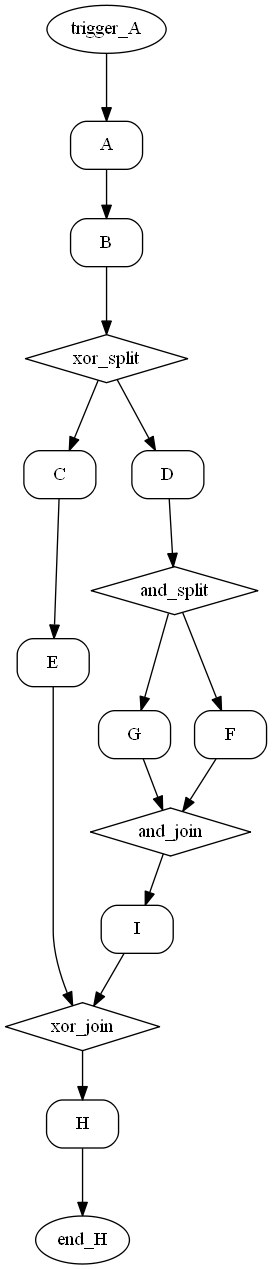

In [281]:
from IPython.display import Image
Image(filename=filename+".png", width=200, height=1000)

### Details: 

In [269]:
alpha.TI

{'A'}

In [267]:
alpha.TO

{'H'}

In [268]:
alpha.TL

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'}

In [270]:
alpha.relations

{'B': {'B': '#',
  'E': '#',
  'C': '->',
  'H': '#',
  'I': '#',
  'G': '#',
  'F': '#',
  'D': '->',
  'A': '<-'},
 'E': {'B': '#',
  'E': '#',
  'C': '<-',
  'H': '->',
  'I': '#',
  'G': '#',
  'F': '#',
  'D': '#',
  'A': '#'},
 'C': {'B': '<-',
  'E': '->',
  'C': '#',
  'H': '#',
  'I': '#',
  'G': '#',
  'F': '#',
  'D': '#',
  'A': '#'},
 'H': {'B': '#',
  'E': '<-',
  'C': '#',
  'H': '#',
  'I': '<-',
  'G': '#',
  'F': '#',
  'D': '#',
  'A': '#'},
 'I': {'B': '#',
  'E': '#',
  'C': '#',
  'H': '->',
  'I': '#',
  'G': '<-',
  'F': '<-',
  'D': '#',
  'A': '#'},
 'G': {'B': '#',
  'E': '#',
  'C': '#',
  'H': '#',
  'I': '->',
  'G': '#',
  'F': '||',
  'D': '<-',
  'A': '#'},
 'F': {'B': '#',
  'E': '#',
  'C': '#',
  'H': '#',
  'I': '->',
  'G': '||',
  'F': '#',
  'D': '<-',
  'A': '#'},
 'D': {'B': '<-',
  'E': '#',
  'C': '#',
  'H': '#',
  'I': '#',
  'G': '->',
  'F': '->',
  'D': '#',
  'A': '#'},
 'A': {'B': '->',
  'E': '#',
  'C': '#',
  'H': '#',
  'I': '#',
 

In [271]:
alpha.XL

{'->': [('F', 'I'),
  ('B', 'C'),
  ('G', 'I'),
  ('E', 'H'),
  ('D', 'G'),
  ('D', 'F'),
  ('A', 'B'),
  ('C', 'E'),
  ('B', 'D'),
  ('I', 'H')],
 '->#': [('B', ['C', 'D'])],
 '#->': [(['E', 'I'], 'H')],
 '->||': [('D', ['G', 'F'])],
 '||->': [(['F', 'G'], 'I')]}

In [273]:
alpha.YL

{'->': [('A', 'B'), ('C', 'E')],
 '->#': [('B', ['C', 'D'])],
 '#->': [(['E', 'I'], 'H')],
 '->||': [('D', ['G', 'F'])],
 '||->': [(['F', 'G'], 'I')]}

In [274]:
alpha.get_relation_df()

,A,B,C,D,E,F,G,H,I
A,#,->,#,#,#,#,#,#,#
B,<-,#,->,->,#,#,#,#,#
C,#,<-,#,#,->,#,#,#,#
D,#,<-,#,#,#,->,->,#,#
E,#,#,<-,#,#,#,#,->,#
F,#,#,#,<-,#,#,||,#,->
G,#,#,#,<-,#,||,#,#,->
H,#,#,#,#,<-,#,#,#,<-
I,#,#,#,#,#,<-,<-,->,#
